# Data
Description: https://www.kaggle.com/c/asap-aes/data

The dataset contains essay and scores they received. There are three raters for two domains, but as we'll see, we will focus on only one rater. Moreover, there are "rater trait" variables which we can also discard, because we won't have such variables available on test sets.

The essay text had _entities_ removed and replaced with there generic name using an off-the-shelf [named entity recognition model](https://nlp.stanford.edu/software/CRF-NER.shtml). This includes seven entities: "PERSON", "ORGANIZATION", "LOCATION", "DATE", "TIME", "MONEY", and "PERCENT". For example, "Mike Smith ate dinner" --> "PERSON1 ate dinner." Note that the word was numbered too.

Additionally, six other entities were replaced:
1. "EMAIL" (anything that looks like an e-mail address)
2. "NUM" (word containing digits or non-alphanumeric symbols)
3. "CAPS" (any capitalized word that doesn't begin a sentence, except in essays where more than 20% of the characters are capitalized letters)
4. "DR" (any word following "Dr." with or without the period, with any capitalization, that doesn't fall into any of the above)
5. "CITY" (any city)
6. "STATE" (any state)

In [116]:
import numpy as np
import pandas as pd
%matplotlib inline

In [75]:
# Training set
train = pd.read_excel('asap-aes/training_set_rel3.xlsx')
train.shape

(12978, 28)

In [76]:
# View head
train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning
The total dataset has 28 columns but many of them turn out to be useless for our purposes, so we will drop them. 
There are 8 essay prompts. Let's group by `essay_prompt` and count the values.

In [78]:
# essay_set
train.groupby('essay_set').count()

,essay_id,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_set,,,,,,,,,,,,,,,,,,,,,
1,1783,1783,1783,1783,0,1783,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1800,1800,1800,1800,0,1800,1800,1800,1800,0,...,0,0,0,0,0,0,0,0,0,0
3,1726,1726,1726,1726,0,1726,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1772,1772,1771,1771,0,1771,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1805,1805,1805,1805,0,1805,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1800,1800,1800,1800,0,1800,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1569,1569,1569,1569,0,1569,0,0,0,1569,...,1569,1569,0,0,0,0,0,0,0,0
8,723,723,723,723,128,723,0,0,0,723,...,723,723,723,723,128,128,128,128,128,128


Note that:
1. There are three scorers for domain1, however, the _resolved score_, `domain1_score`, is our target variable. You can tell `domain1_score` is the target variable by seeing that its range is consistent with the sample submissions in `valid_sample_submission_5_column.csv`. Since the three scores are superfluous, and we won't have those variables in we drop them (`rater1_domain1`, `rater2_domain1`, `rater3_domain1`).
2. Each `essay_set` has its own prompt. The prompts can vary widely, so I focus on just one to start. I will look at only `essay_set==1`. Then, if the model is working, then I will generalize to all eight essay sets.
3. The _domain2_ scores apply to only `essay_id==2`, so I will drop them for now.
4. There are 6 trains for the three raters. I think these are characteristics of the person who is rating the essay. These personal characterestics should not be included because we cannot use them as predictive variables on test sets.

In [96]:
# Simplify data
train1 = train.loc[train.essay_set==1,:].drop(columns=['rater1_domain1', 'rater2_domain1', 'rater3_domain1']).iloc[:,0:4]

In [109]:
# descriptive statistics
train1.domain1_score.describe()

count    1783.000000
mean        8.528323
std         1.538565
min         2.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: domain1_score, dtype: float64

The target variable ranges from 2 to 12, in discrete values.

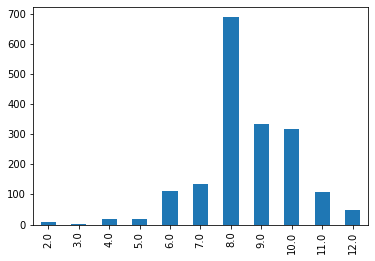

In [130]:
# frequency of target variable
train1.domain1_score.value_counts().sort_index().plot.bar();

Now that we simplified and cleaned the data, we turn to modeling.